In [51]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Objective function to minimize 

objective_function_name = input("Enter the objective function name (sphere, rosenbrock, ackley, schwefel, rastrigin): ")  # Choose the objective function to minimize

if objective_function_name == 'schwefel':
    lower_bound = -500
    upper_bound = 500
elif objective_function_name == 'rastrigin':
    lower_bound = -5.12
    upper_bound = 5.12
else:
    lower_bound = -10
    upper_bound = 10

def objective_function(x, function_name):
    if function_name == 'sphere':
        return sphere_function(x)
    elif function_name == 'rosenbrock':
        return rosenbrock_function(x)
    elif function_name == 'ackley':
        return ackley_function(x)
    elif function_name == 'schwefel':
        return schwefel_function(x)
    elif function_name == 'rastrigin':
        return rastrigin_function(x)
    else:
        raise ValueError("Unknown function name")

def sphere_function(x):
    return np.sum(x**2) 

def rosenbrock_function(x):
    return sum(100.0 * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)

def ackley_function(x):
    first_sum = np.sum(x**2)
    second_sum = np.sum(np.cos(2 * np.pi * x))
    n = len(x)
    return -20 * np.exp(-0.2 * np.sqrt(first_sum / n)) - np.exp(second_sum / n) + 20 + np.e

def rastrigin_function(x):
    # Domain: [-5.12, 5.12] typically
    return 10 * len(x) + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))

def schwefel_function(x):
    # Domain: [-500, 500] typically. Global min at [420.9687, ...] -> f(x)=0
    return 418.9829 * len(x) - np.sum(x * np.sin(np.sqrt(np.abs(x))))

In [52]:
# Parameters settings for a Consessus-Based Optimization (CBO) algorithm
num_particles = 100
max_iterations = 200
domain_size = upper_bound - lower_bound # To scale parameters according to the search space size
alpha_start = 0.01  # More exploration at the beginning
alpha_end = 50.0 # More exploitation at the end
lambda_ = 1.0 # Drift parameter
sigma_0 = 0.05 # Diffusion parameter
gamma = 0.01 # Decay rate
delta_t = 0.1 # Time step

bounds = np.array([[lower_bound, lower_bound, lower_bound],
                    [upper_bound, upper_bound, upper_bound]]) # Search space boundaries for each dimension
particles = np.random.uniform(bounds[0], bounds[1], (num_particles, 3)) # Initial positions of particles

# Initialize global best position and cost
global_best_position = particles[0].copy()
global_best_cost = float('inf')

# Store initial particles and history of best costs
initial_particles = particles.copy()
history_best_cost = []

Converged after 125 iterations.
Weighted swarm radius: 0.000923 < epsilon (0.001)
Total execution time: 0.11 seconds


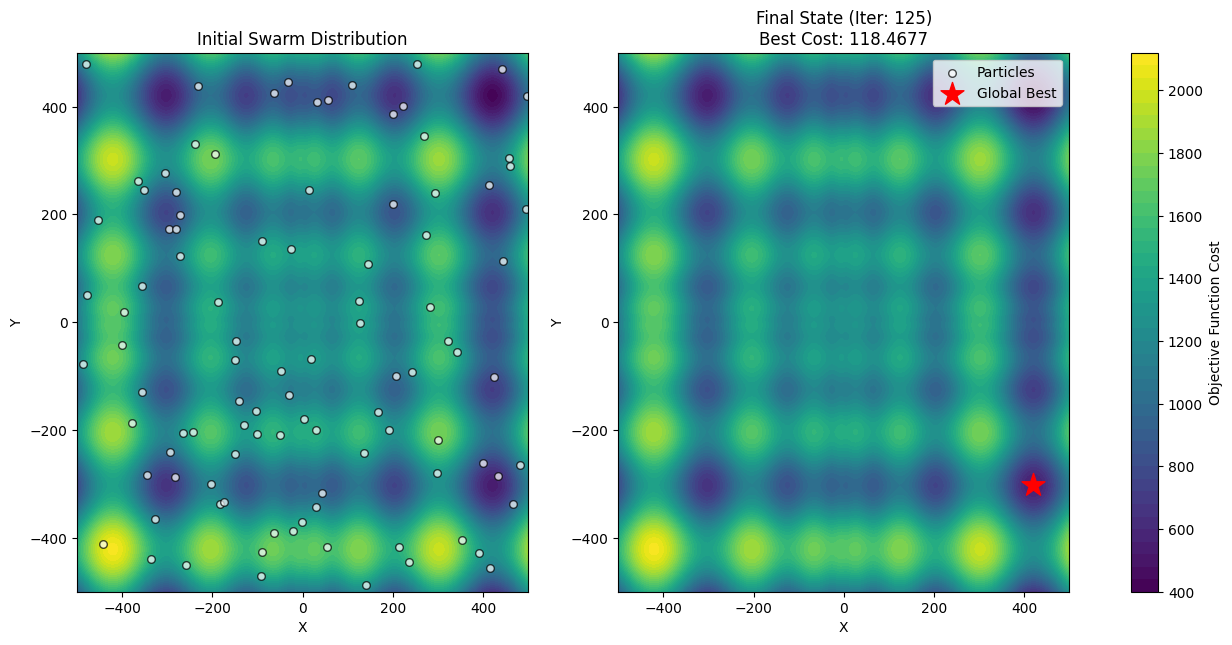

In [53]:
# Perform the optimization loop
def cbo_optimization():
    global particles, global_best_position, global_best_cost, alpha

    epsilon = 1e-3 # Convergence threshold

    for iteration in range(max_iterations):
        
        # Update alpha for exploration-exploitation trade-off
        alpha = alpha_start + (alpha_end - alpha_start) * (iteration / max_iterations)

        # Cost evaluation and weights computation
        costs = np.array([objective_function(p, objective_function_name) for p in particles])

        # Update global best
        current_best_index = np.argmin(costs)
        if costs[current_best_index] < global_best_cost: 
            global_best_cost = costs[current_best_index]
            global_best_position = particles[current_best_index].copy() 
        history_best_cost.append(global_best_cost)
        
        # Update weights based on costs
        v_min = np.min(costs) # For numerical stability
        weights = np.exp(-alpha * (costs - v_min))

        # Normalize weights
        sum_weights = np.sum(weights)
        if sum_weights > 0:
            weights /= sum_weights
        else:
            # Case all weights are zero (can happen with large alpha)
            weights = np.ones(num_particles) / num_particles

        consensus_point = np.sum(weights[:, np.newaxis] * particles, axis=0)

        diffusion_vector = particles - consensus_point # Diffusion vector for each particle

        drift = -lambda_ * diffusion_vector * delta_t # Drift towards consensus point

        dist_scalar = np.linalg.norm(diffusion_vector, axis=1, keepdims=True) # Distance from consensus point for each particle

        zi = np.random.randn(num_particles, 3) # Standard normal random variables
        sigma_scaled = sigma_0 * np.exp(-gamma * iteration) # Decaying diffusion coefficient
        diffusion = sigma_scaled * dist_scalar * np.sqrt(delta_t) * zi # Diffusion component

        particles += drift + diffusion # Update particle positions
        particles = np.clip(particles, bounds[0], bounds[1]) # Keep particles within bounds

        weighted_swarm_radius = np.sum(weights * dist_scalar.flatten())
    
        if weighted_swarm_radius < epsilon and iteration > 30:
            print(f"Converged after {iteration} iterations.")
            print(f"Weighted swarm radius: {weighted_swarm_radius:.6f} < epsilon ({epsilon})")
            return iteration


range_width = upper_bound - lower_bound
density = 10 # Points per unit range
min_points = 100
max_points = 400 
num_points = int(min(max(min_points, range_width * density), max_points))

x = np.linspace(lower_bound, upper_bound, num_points)
y = np.linspace(lower_bound, upper_bound, num_points)
X, Y = np.meshgrid(x, y)

Z = np.array([[objective_function(np.array([i, j, 0]), objective_function_name) for i in x] for j in y])

initial_particles = particles.copy() # Initial state for later comparison

# Run the CBO optimization and measure execution time
total_execution_time = time.time()
tot_iterations = cbo_optimization()
total_execution_time = time.time() - total_execution_time
print(f"Total execution time: {total_execution_time:.2f} seconds")

def plot_cbo_state(ax, particle_data, title, show_best=False):
    # Background contour plot of the objective function
    contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
    
    # Draw all particles
    ax.scatter(particle_data[:, 0], particle_data[:, 1], c='white', edgecolors='black', s=30, alpha=0.7, label='Particles')
    
    # If requested, highlight the Global Best (only in the final plot)
    if show_best:
        ax.scatter(global_best_position[0], global_best_position[1], 
                   c='red', marker='*', s=300, label='Global Best') # s=300 is the size of the star
        ax.legend()
        
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    return contour

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

plot_cbo_state(ax1, initial_particles, "Initial Swarm Distribution")

contour = plot_cbo_state(ax2, particles, f"Final State (Iter: {tot_iterations if tot_iterations is not None else max_iterations})\nBest Cost: {global_best_cost:.4f}", show_best=True)

fig.colorbar(contour, ax=[ax1, ax2], label='Objective Function Cost')

plt.show()